This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Fundamentals of machine learning

## Generalization: The goal of machine learning

### Underfitting and overfitting

#### Noisy training data

#### Ambiguous features

#### Rare features and spurious correlations

**Adding white-noise channels or all-zeros channels to MNIST**

In [5]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

In [6]:
train_images_with_noise_channels.shape

(60000, 1568)

**Training the same model on MNIST data with noise channels or all-zero channels**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 0.2981 - accuracy: 0.9161 - val_loss: 0.1483 - val_accuracy: 0.9573
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1228 - accuracy: 0.9641 - val_loss: 0.1085 - val_accuracy: 0.9693
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0807 - accuracy: 0.9765 - val_loss: 0.0913 - val_accuracy: 0.9732
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.9828 - val_loss: 0.0895 - val_accuracy: 0.9742
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.0799 - val_accuracy: 0.9763
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0332 - accuracy: 0.9904 - val_loss: 0.0781 - val_accuracy: 0.9772
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.0795 - val_accuracy: 0.9772
Epoch 

**Plotting a validation accuracy comparison**

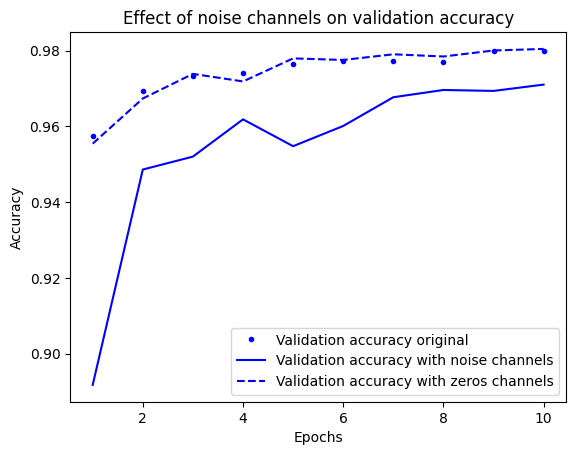

In [12]:
import matplotlib.pyplot as plt
val_acc = history.history["val_accuracy"]
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc, "b.",
         label="Validation accuracy original")
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

### The nature of generalization in deep learning

**Fitting a MNIST model with randomly shuffled labels**

In [13]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history= model.fit(train_images, random_train_labels,
          epochs=30,
          batch_size=128,
          validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 3s 6ms/step - loss: 2.3144 - accuracy: 0.1023 - val_loss: 2.3034 - val_accuracy: 0.1047
Epoch 2/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2995 - accuracy: 0.1176 - val_loss: 2.3108 - val_accuracy: 0.1094
Epoch 3/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2920 - accuracy: 0.1262 - val_loss: 2.3148 - val_accuracy: 0.1011
Epoch 4/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2803 - accuracy: 0.1354 - val_loss: 2.3232 - val_accuracy: 0.1004
Epoch 5/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2660 - accuracy: 0.1478 - val_loss: 2.3360 - val_accuracy: 0.1077
Epoch 6/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2483 - accuracy: 0.1611 - val_loss: 2.3442 - val_accuracy: 0.1044
Epoch 7/30
375/375 [==============================] - 2s 6ms/step - loss: 2.2238 - accuracy: 0.1774 - val_loss: 2.3556 - val_accuracy: 0.1076
Epoch 

** As it turns out, the nature of generalization in deep learning has rather little to do
with deep learning models themselves, and much to do with the structure of information in the real world. Let’s take a look at what’s really going on here**

In [14]:
import matplotlib.pyplot as plt
def plot_history(history):

    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    # Sample data (replace with your actual data)
    epochs = range(1, len(train_loss) + 1)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

    # Plot loss on the upper subplot
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_loss, color='tab:blue', label='Training Loss')
    ax1.plot(epochs, val_loss, color='tab:red', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    # Plot accuracy on the lower subplot
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy', color='tab:green')
    ax2.plot(epochs, [acc * 100 for acc in train_acc], color='tab:blue', label='Training Accuracy (%)')
    ax2.plot(epochs, [acc * 100 for acc in val_acc], color='tab:red', label='Validation Accuracy (%)')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')

    ax2.yaxis.set_label_position('right')  # Set the y-axis label to the right
    ax2.yaxis.set_ticks_position('right')  # Set the y-axis ticks to the right

    # Add a title
    plt.suptitle('Training and Validation Loss & Accuracy Over Epochs')

    # Display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

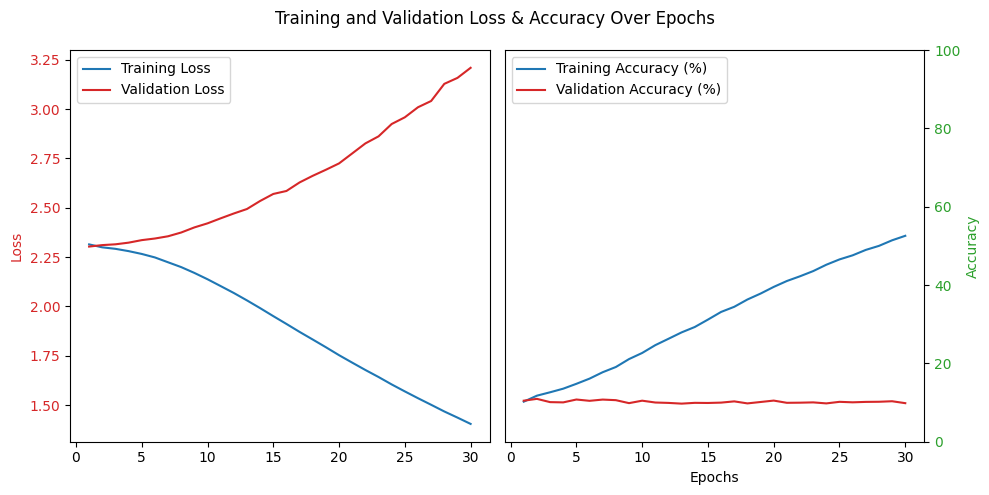

In [15]:
plot_history(history)

## The manifold hypothesis

#### Interpolation as a source of generalization

#### Why deep learning works

#### Training data is paramount

## Evaluating machine-learning models

### Training, validation, and test sets

#### Simple hold-out validation

#### K-fold validation

#### Iterated K-fold validation with shuffling

### Beating a common-sense baseline (give example like mcqs)

## Improving model fit

### Tuning key gradient descent parameters

**Training a MNIST model with an incorrectly high learning rate**

In [16]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 6ms/step - loss: 725.0253 - accuracy: 0.3263 - val_loss: 2.2538 - val_accuracy: 0.1398
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 2.6197 - accuracy: 0.1775 - val_loss: 2.1857 - val_accuracy: 0.1864
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 2.5199 - accuracy: 0.1679 - val_loss: 2.4775 - val_accuracy: 0.1750
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 2.4203 - accuracy: 0.1621 - val_loss: 2.3058 - val_accuracy: 0.1664
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 2.4474 - accuracy: 0.1792 - val_loss: 2.2823 - val_accuracy: 0.1753
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 2.4129 - accuracy: 0.1874 - val_loss: 2.2438 - val_accuracy: 0.1599
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 2.5168 - accuracy: 0.1715 - val_loss: 2.3924 - val_accuracy: 0.1733
Epoc

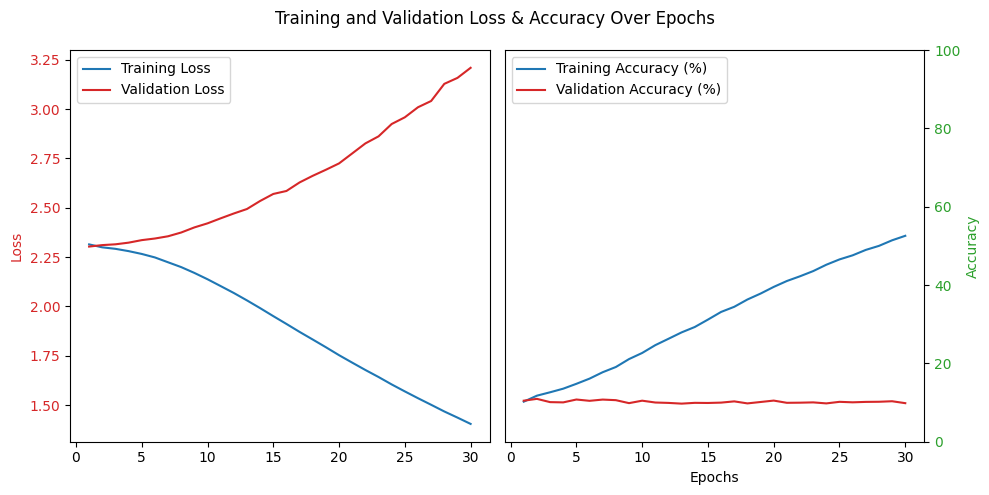

In [17]:
plot_history(history)

**The same model with a more appropriate learning rate**

In [23]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
                  
history = model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2892 - accuracy: 0.9167 - val_loss: 0.1518 - val_accuracy: 0.9569
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1219 - accuracy: 0.9643 - val_loss: 0.1144 - val_accuracy: 0.9650
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0805 - accuracy: 0.9762 - val_loss: 0.0912 - val_accuracy: 0.9743
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.9829 - val_loss: 0.0847 - val_accuracy: 0.9740
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0438 - accuracy: 0.9871 - val_loss: 0.0745 - val_accuracy: 0.9784
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0323 - accuracy: 0.9910 - val_loss: 0.0772 - val_accuracy: 0.9776
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0808 - val_accuracy: 0.9771
Epoch 

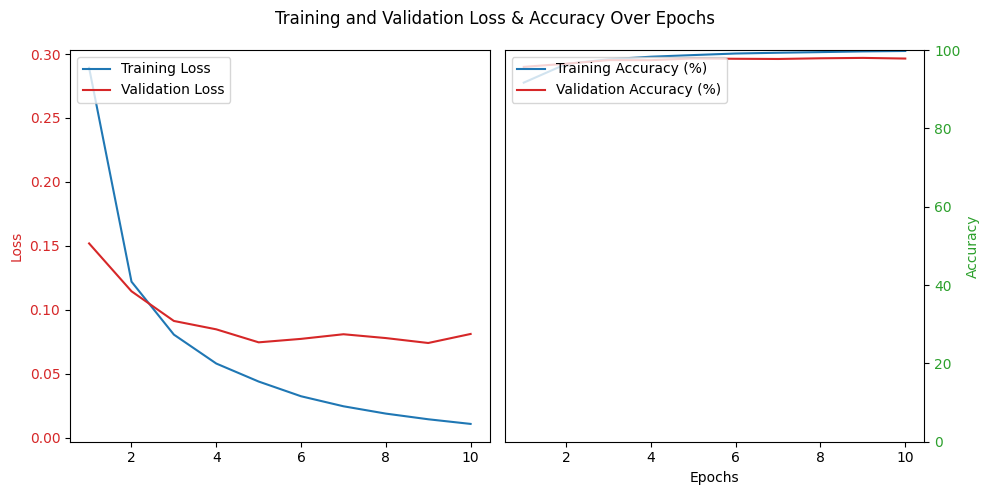

In [24]:
plot_history(history)

### Leveraging better architecture priors

### Increasing model capacity

**A simple logistic regression on MNIST**

In [ ]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

## Improving generalization

### Dataset curation

### Feature engineering

### Using early stopping

### Regularizing your model

#### Reducing the network's size

**Original model**

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with lower capacity**

In [ ]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Version of the model with higher capacity**

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [ ]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

**Different weight regularizers available in Keras**

In [ ]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout

**Adding dropout to the IMDB model**

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

## Summary